# Day 15: Oxygen System

https://adventofcode.com/2019/day/15

## Part 1

### Map the maze

Some inspiration on the map mapping algorithm from this page:

https://sites.google.com/site/advancedpythonprogramming/recursion/exploring-a-maze

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from AOC2019 import Intcode, readIntcodeProg

In [2]:
prog = readIntcodeProg("./data/input15.txt")

In [3]:
# Only four movement commands are understood: north (1), south (2), west (3), and east (4).
N = 1
S = 2
W = 3
E = 4

def move(d,x):
    x1 = np.copy(x)
    if   d==N:
        x1 += np.array([0,+1])
    elif d==S:
        x1 += np.array([0,-1])
    elif d==W:
        x1 += np.array([-1,0])
    elif d==E:
        x1 += np.array([+1,0])
    else:
        print("Illegal movement!")
    return x1

x0 = np.array([50,50])
x1 = move(N,x0)
print(x0,x1)

[50 50] [50 51]


In [4]:
WALL= 1
SEEN = -1
OXIGEN = 2

In [5]:
# area and starting position (area size to be optimized after having found the oxigen)
shape = (41,41)
area = np.zeros(shape)
x0 = np.array([21,19])

# initialize intcode computer
droid = Intcode(prog,"DROID")

def nextdir(d):
    '''Cycle between directions (N-S-W-E)'''
    nd = d + 1
    if nd > 4: 
        nd = 1
    return nd

def newdir(x0,olddir):
    '''Algorithm to decide new direction after step'''
    # gather info about already-explored area
    xN = move(N,x0)
    xS = move(S,x0)
    xW = move(W,x0)
    xE = move(E,x0)
    dirs = [ xN, xS, xW, xE ]
    status = []
    for d in dirs:
        status.append(area[d[1]][d[0]])
    oldd = olddir    
    tiles = [p!=0 for p in status]
    # goes toward next non explored direction in standard iteration (N-S-W-E) excluding walls
    while( np.absolute(np.array(tiles)).sum() < 4 ): # All walls or already explored
        newd = nextdir(oldd)
        if status[newd-1]==0:
            return newd
        else:
            oldd = newd
    # if all walls or already explored, go toward least visited non-wall direction
    tiles = []
    for s in status:
        if (s==WALL): tiles.append(-10000000) # replace WALL with very negative value
        else: tiles.append(s)
    return tiles.index(max(tiles))+1
    
# mark starting point for visualisation purposes
area[x0[1]][x0[0]] = OXIGEN
            
# begin by moving N            
direction = N 

# Debug steps
istep = 0
istepmax = 3000

while(True):
#while(istep<istepmax):
    
    istep += 1
    #if istep%100==0:
    #    print("*",end="")
    
    x1 = move(direction,x0)
    droid.runProgram(direction)
    o = droid.getLastOutput()

    if o==0: # 0: The repair droid hit a wall. Its position has not changed.
        area[x1[1]][x1[0]] = WALL
        direction = newdir(x0,direction)
    elif o==1: # 1: The repair droid has moved one step in the requested direction.
        area[x1[1]][x1[0]] += SEEN
        #area[x1[1]][x1[0]] = SEEN
        x0 = x1
        direction = newdir(x0,direction)
    elif o==2:  # 2: The repair droid has moved one step in the requested direction; its new position is the location of the oxygen system.
        area[x1[1]][x1[0]] = OXIGEN
        print("OXIGEN found! Location =",x1)
        break

print("Steps = ",istep)

OXIGEN found! Location = [35 39]
Steps =  2143


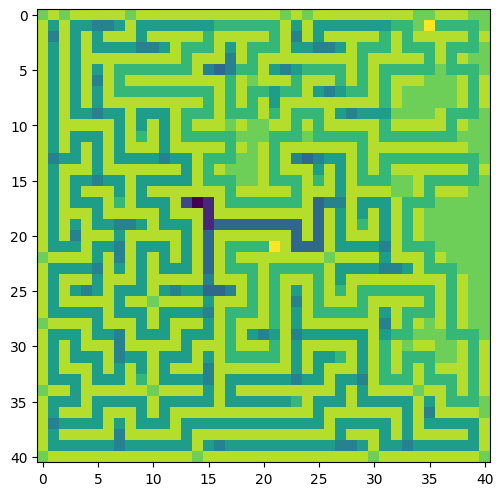

In [6]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(np.flip(area,0))

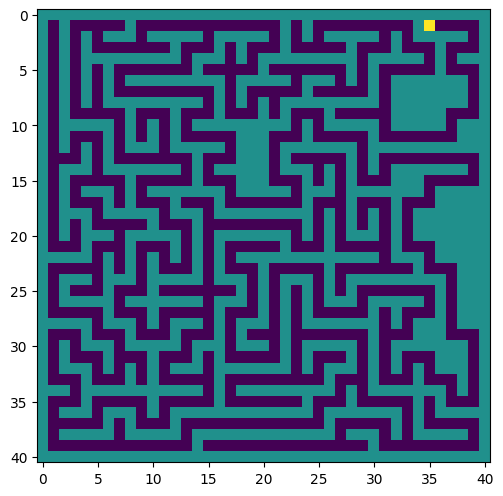

In [7]:
# Reformat map removing trace of explored path

maze = np.copy(area)
# Replace all remaingin zeros with WALL
maze[maze==0] = WALL
# Replace negative values (PATH) with 0 
maze[maze<0] = 0

IN  = np.array([21,19])
OUT = np.array([35,39])

maze[IN[1],IN[0]] = 0 # reset entry point to 0

fig = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(np.flip(maze,0))

### Solve the maze

Problem: find fewest number of movement commands required to move the repair droid from its starting position to the location of the oxygen system.

Solution: Backtracking algorithm (https://en.wikipedia.org/wiki/Backtracking) implemented with recursion

Inspiration from https://www.101computing.net/backtracking-maze-path-finder/

In [16]:
# A backtracking/recursive function to check all possible paths until the exit is found

EMPTY = 0
WALL  = 1
EXIT  = 2
SEEN  = 3
BACKTRACK = 4

def exploreMaze(maze,row,col):
    
    #plt.imshow(np.flip(maze,0))
    #camera.snap()
    
    if maze[row][col]==EXIT:
        return True
    elif maze[row][col]==EMPTY: # Empty path, not yet explored
        maze[row][col]=SEEN
        if row<len(maze)-1:
            # Explore path below
            if exploreMaze(maze,row+1,col):
                return True
        if row>0:
            # Explore path above
            if exploreMaze(maze,row-1,col):
                return True
        if col<len(maze[row])-1:
            # Explore path to the right
            if exploreMaze(maze,row,col+1):
                return True
        if col>0:
            # Explore path to the left
            if exploreMaze(maze,row,col-1):
                return True
        # Backtrack
        maze[row][col]=BACKTRACK      
        #print("Backtracking")

solved = exploreMaze(maze,IN[1],IN[0])

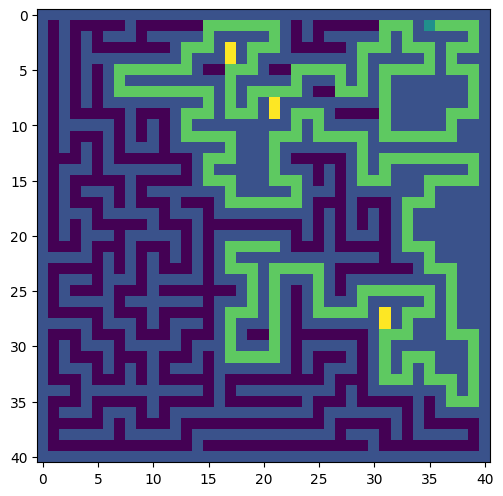

In [17]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(np.flip(maze,0))

In [10]:
bestpath = int((maze[maze==SEEN]/SEEN).sum())
print("Fewest number of movement commands =",bestpath)

Fewest number of movement commands = 282


## Part 2

How many minutes will it take to fill with oxygen?

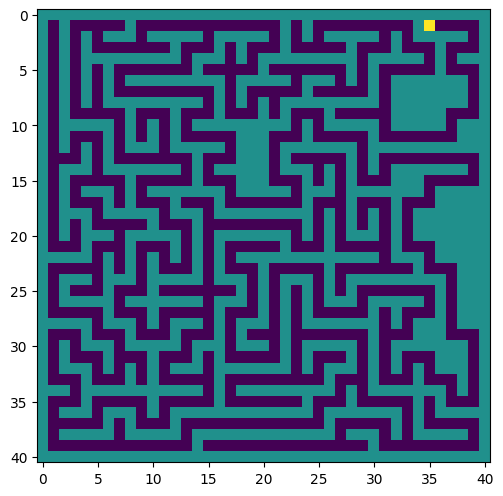

In [11]:
# Reformat maze area

IN  = np.array([21,19])
OUT = np.array([35,39])

maze[maze==3] = EMPTY
maze[maze==4] = EMPTY
maze[OUT[1],OUT[0]] = OXIGEN

fig = plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(np.flip(maze,0))

Time to fill = 286 minutes


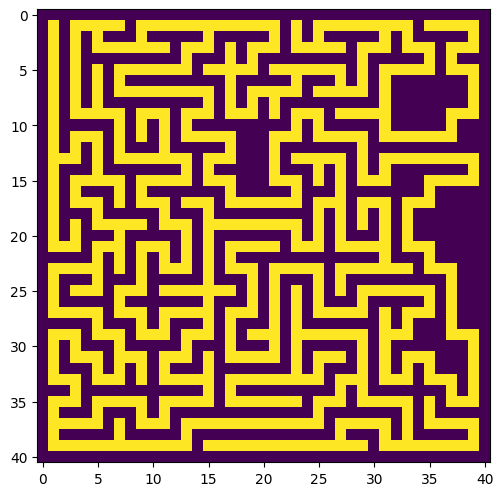

In [14]:
def fillAdjacents(maze,x0list):
    adj = []
    for x0 in x0list:
        # gather info about already-explored area
        xN = move(N,x0)
        xS = move(S,x0)
        xW = move(W,x0)
        xE = move(E,x0)
        dirs = [ xN, xS, xW, xE ]
        for d in dirs:
            if maze[d[1]][d[0]] == EMPTY:
                maze[d[1]][d[0]] = OXIGEN # fill empty cells
                adj.append(d) # return list of filled cells
    return adj

from celluloid import Camera
fig = plt.figure(figsize=(6, 6), dpi=100)
camera = Camera(fig)

# make a copy for the sake of quick debug
maze_ = maze.copy()

adj = [ OUT ] # start from OXIGEN generator location
time = 0
while(len(maze_[maze_==EMPTY])):
    time += 1
    newadj = fillAdjacents(maze_,adj)
    adj = list(newadj)
    plt.imshow(np.flip(maze_,0))
    camera.snap()

print("Time to fill =",time,"minutes")

In [18]:
print("Saving animation... ",end="")
anim = camera.animate(blit=True)
anim.save('./visualisation/day15animation.gif', writer='imagemagick')
print("Animation saved.")

Saving animation... Animation saved.


![Oxigen flow](./visualisation/day15animation.gif "Oxigen flow")